In [1]:
# Install necessary packages
%pip install -q -U scikit-learn pandas numpy joblib scipy optuna matplotlib ipywidgets xgboost lightgbm pywavelets seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install necessary packages
# If running in a Jupyter notebook or similar environment, you may need to install the packages.
# Uncomment and run the following lines if necessary:
# %pip install -q -U scikit-learn pandas numpy joblib scipy optuna matplotlib ipywidgets xgboost lightgbm pywavelets seaborn

# Imports
import json
import pandas as pd
import numpy as np
import joblib
from scipy.fft import fft
from scipy.signal import butter, filtfilt
import pywt  # For wavelet transforms
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import IntSlider, interactive
import time


In [3]:

# Step 1: Load and Correct the Data

# Load the data
with open('cycling_data2.json', 'r') as f:
    data = json.load(f)

# Define gear ratios and wheel circumference
gear_ratios = {
    1: 38.0 / 11.0,
    2: 38.0 / 15.0,
    3: 38.0 / 18.0,
    4: 38.0 / 21.0,
    5: 38.0 / 24.0,
    6: 38.0 / 34.0,
    # Add all your gear ratios
}
wheel_circumference = 2.19999  # in meters

# Flatten the data and recalculate cadence
records = []
for session in data:
    for point in session['data']:
        gear = point['gear']
        speed = point['speed']  # in m/s
        gear_ratio = gear_ratios.get(gear, None)
        if gear_ratio and speed > 0:
            cadence = (speed / wheel_circumference) * gear_ratio * 60
        else:
            cadence = 0.0
        point['cadence'] = cadence
        records.append({
            'timestamp': point['timestamp'],
            'accel_x': point['accelerometerData']['x'],
            'accel_y': point['accelerometerData']['y'],
            'accel_z': point['accelerometerData']['z'],
            'speed': speed,
            'cadence': cadence,
            'gear': gear,
            'terrain': point['terrain'],
            'is_standing': point['isStanding']
        })

# Convert to DataFrame and Ensure Temporal Order

df = pd.DataFrame(records)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)


In [4]:

# Step 2: Define Functions for Feature Extraction and Signal Processing

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def extract_features(window, include_fft=True, apply_filter=False, include_wavelet=False):
    # Extract accelerometer data
    accel_x = window['accel_x'].values
    accel_y = window['accel_y'].values
    accel_z = window['accel_z'].values

    if apply_filter:
        # Apply band-pass filter
        fs = 50  # Sampling frequency
        lowcut = 0.5
        highcut = 3.0  # Adjust based on expected cadence frequency range
        accel_x = bandpass_filter(accel_x, lowcut, highcut, fs)
        accel_y = bandpass_filter(accel_y, lowcut, highcut, fs)
        accel_z = bandpass_filter(accel_z, lowcut, highcut, fs)

    features = []

    # Time-domain features
    for accel in [accel_x, accel_y, accel_z]:
        features.extend([
            np.mean(accel),
            np.std(accel),
            np.var(accel),
            np.min(accel),
            np.max(accel),
            np.median(accel),
            np.percentile(accel, 25),
            np.percentile(accel, 75),
        ])

    # Frequency-domain features
    if include_fft:
        for accel in [accel_x, accel_y, accel_z]:
            fft_values = fft(accel)
            fft_magnitude = np.abs(fft_values)[:len(fft_values)//2]
            features.extend([
                np.mean(fft_magnitude),
                np.std(fft_magnitude),
                np.max(fft_magnitude),
                np.argmax(fft_magnitude),  # Dominant frequency component
            ])

    # Wavelet features
    if include_wavelet:
        for accel in [accel_x, accel_y, accel_z]:
            coeffs = pywt.wavedec(accel, 'db1', level=3)
            # Use approximation coefficients at the third level
            cA3 = coeffs[0]
            features.extend([
                np.mean(cA3),
                np.std(cA3),
            ])

    # Add speed feature
    features.append(window['speed'].mean())

    return features


In [5]:

# Step 3: Define the Objective Function for Optuna

def objective(trial):
    start_time = time.time()  # Start time for inference time measurement

    # Hyperparameters to tune
    window_size = trial.suggest_int('window_size', 50, 200, step=20)
    window_step = trial.suggest_int('window_step', 50, window_size, step=10)
    include_fft = trial.suggest_categorical('include_fft', [True, False])
    include_wavelet = trial.suggest_categorical('include_wavelet', [True, False])
    scaler_name = trial.suggest_categorical('scaler', ['StandardScaler', 'MinMaxScaler', 'RobustScaler'])
    apply_filter = trial.suggest_categorical('apply_filter', [True, False])
    use_pca = trial.suggest_categorical('use_pca', [True, False])
    n_components = trial.suggest_uniform('n_components', 0.80, 0.99) if use_pca else None
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'XGBoost', 'LightGBM', 'MLP'])

    # Select scaler
    if scaler_name == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_name == 'MinMaxScaler':
        scaler = MinMaxScaler()
    else:
        scaler = RobustScaler()

    # Prepare data
    X = []
    y_cadence = []
    y_terrain = []
    y_position = []
    y_gear = []  # Add gear labels
    X_raw = []  # Store raw accelerometer data and speed

    # Generate windows
    for start_idx in range(0, len(df) - window_size, window_step):
        end_idx = start_idx + window_size
        window = df.iloc[start_idx:end_idx]

        # Extract features
        features = extract_features(window, include_fft=include_fft, apply_filter=apply_filter, include_wavelet=include_wavelet)

        # Append features and labels
        X.append(features)
        y_cadence.append(window['cadence'].mean())
        y_terrain.append(window['terrain'].mode()[0])
        y_position.append(window['is_standing'].mode()[0])
        y_gear.append(window['gear'].mode()[0])  # Collect gear labels

    # Convert to NumPy arrays
    X = np.array(X)
    y_cadence = np.array(y_cadence)
    y_terrain = np.array(y_terrain)
    y_position = np.array(y_position)
    y_gear = np.array(y_gear)  # Convert to array

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Scale features
    X_scaled = scaler.fit_transform(X)

    # Optional PCA
    if use_pca:
        pca = PCA(n_components=n_components)
        X_scaled = pca.fit_transform(X_scaled)

    # Encode labels
    terrain_encoder = LabelEncoder()
    y_terrain_encoded = terrain_encoder.fit_transform(y_terrain)

    position_encoder = LabelEncoder()
    y_position_encoded = position_encoder.fit_transform(y_position)

    # Time-based splitting
    split_index = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train_cadence, y_test_cadence = y_cadence[:split_index], y_cadence[split_index:]
    y_train_terrain, y_test_terrain = y_terrain_encoded[:split_index], y_terrain_encoded[split_index:]
    y_train_position, y_test_position = y_position_encoded[:split_index], y_position_encoded[split_index:]
    y_train_gear, y_test_gear = y_gear[:split_index], y_gear[split_index:]  # Split gear labels

    # Select and train model
    if model_type == 'RandomForest':
        cadence_model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'XGBoost':
        cadence_model = xgb.XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='rmse')
    elif model_type == 'LightGBM':
        cadence_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    elif model_type == 'MLP':
        cadence_model = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=500)
    else:
        cadence_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Default

    cadence_model.fit(X_train, y_train_cadence)

    # Measure inference time
    inference_start_time = time.time()
    y_pred_cadence = cadence_model.predict(X_test)
    inference_time = time.time() - inference_start_time

    # Evaluate model
    mae_cadence = mean_absolute_error(y_test_cadence, y_pred_cadence)

    # Compute cost: combination of MAE and inference time
    alpha = 0.1  # Adjust this weight as needed
    cost = mae_cadence + alpha * inference_time

    # Store additional trial information
    trial.set_user_attr("inference_time", inference_time)
    trial.set_user_attr("mae_cadence", mae_cadence)
    trial.set_user_attr("window_size", window_size)
    trial.set_user_attr("window_step", window_step)
    trial.set_user_attr("model_type", model_type)

    return cost  # Minimizing cost function that includes inference time


In [6]:

# Step 4: Run the Optimization with Optuna
minutes = 2  # Set the time limit for optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout= minutes * 60 )  # Run for 2 minutes or until success criteria are met


[I 2024-11-01 15:50:34,427] A new study created in memory with name: no-name-180d3f4b-79bf-45fb-b023-5d8d8c7828e1
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-11-01 15:50:41,050] Trial 0 finished with value: 2.4086410971417656 and parameters: {'window_size': 170, 'window_step': 140, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'MLP'}. Best is trial 0 w

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 4
[LightGBM] [Info] Start training from score 5.793834


[I 2024-11-01 15:51:06,613] Trial 8 finished with value: 2.775211033184533 and parameters: {'window_size': 150, 'window_step': 130, 'include_fft': True, 'include_wavelet': False, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': True, 'n_components': 0.8431884818134836, 'model_type': 'LightGBM'}. Best is trial 0 with value: 2.4086410971417656.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2238, number of used features: 31
[LightGBM] [Info] Start training from score 5.783158


[I 2024-11-01 15:51:10,163] Trial 9 finished with value: 2.5978495013926626 and parameters: {'window_size': 70, 'window_step': 70, 'include_fft': False, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': True, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 0 with value: 2.4086410971417656.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/var/folders/57/nty5xpxn58j6m805vlm1nxn80000gp/T/ipykernel_79021/3639481563.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  n_components = trial.suggest_uniform('n_components', 0.80, 0.99) if use_pca else None
[I 2024-11-01 15:51:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1566, number of used features: 31
[LightGBM] [Info] Start training from score 5.776466


[I 2024-11-01 15:51:13,755] Trial 11 finished with value: 2.58448272319679 and parameters: {'window_size': 190, 'window_step': 100, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': True, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 0 with value: 2.4086410971417656.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7903
[LightGBM] [Info] Number of data points in the train set: 1566, number of used features: 31
[LightGBM] [Info] Start training from score 5.776466


[I 2024-11-01 15:51:15,657] Trial 12 finished with value: 2.302506115575634 and parameters: {'window_size': 190, 'window_step': 100, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
[I 2024-11-01 15:51:17,668] Trial 13 finished with value: 2.3701134652060953 and parameters: {'window_size': 170, 'window_step': 160, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'RandomForest'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Library/CloudStorage/OneDrive-Imperia

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1740, number of used features: 31
[LightGBM] [Info] Start training from score 5.799878


[I 2024-11-01 15:51:29,970] Trial 17 finished with value: 2.4104022005749983 and parameters: {'window_size': 130, 'window_step': 90, 'include_fft': False, 'include_wavelet': True, 'scaler': 'MinMaxScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/var/folders/57/nty5xpxn58j6m805vlm1nxn80000gp/T/ipykernel_79021/3639481563.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  n_components = trial.suggest_uniform('n_components', 0.80, 0.99) if use_pca else None


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1740, number of used features: 15
[LightGBM] [Info] Start training from score 5.790530


[I 2024-11-01 15:51:31,887] Trial 18 finished with value: 2.6094268920681145 and parameters: {'window_size': 150, 'window_step': 90, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': True, 'n_components': 0.987292810598718, 'model_type': 'LightGBM'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
[I 2024-11-01 15:51:34,578] Trial 19 finished with value: 2.337673469146466 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'RandomForest'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Libr

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 31
[LightGBM] [Info] Start training from score 5.824196


[I 2024-11-01 15:51:36,699] Trial 20 finished with value: 2.4868869952679096 and parameters: {'window_size': 130, 'window_step': 80, 'include_fft': False, 'include_wavelet': True, 'scaler': 'MinMaxScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
[I 2024-11-01 15:51:39,392] Trial 21 finished with value: 2.3376687961423155 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'RandomForest'}. Best is trial 12 with value: 2.302506115575634.
/Users/lj321/Library/CloudStorage/OneDrive-Imperia

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 31
[LightGBM] [Info] Start training from score 5.801801


[I 2024-11-01 15:51:54,522] Trial 27 finished with value: 2.2461428699505843 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 27 with value: 2.2461428699505843.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 31
[LightGBM] [Info] Start training from score 5.818786


[I 2024-11-01 15:51:56,610] Trial 28 finished with value: 2.453535804648406 and parameters: {'window_size': 110, 'window_step': 80, 'include_fft': False, 'include_wavelet': True, 'scaler': 'MinMaxScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 27 with value: 2.2461428699505843.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 1119, number of used features: 31
[LightGBM] [Info] Start training from score 5.815153


[I 2024-11-01 15:51:58,097] Trial 29 finished with value: 2.417797334113641 and parameters: {'window_size': 170, 'window_step': 140, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 27 with value: 2.2461428699505843.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 31
[LightGBM] [Info] Start training from score 5.824196


[I 2024-11-01 15:52:00,209] Trial 30 finished with value: 2.4210681660514592 and parameters: {'window_size': 130, 'window_step': 80, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 27 with value: 2.2461428699505843.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 31
[LightGBM] [Info] Start training from score 5.801801


[I 2024-11-01 15:52:01,805] Trial 31 finished with value: 2.246116024018577 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 31
[LightGBM] [Info] Start training from score 5.801801


[I 2024-11-01 15:52:03,422] Trial 32 finished with value: 2.2461273489010845 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7903
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 31
[LightGBM] [Info] Start training from score 5.784228


[I 2024-11-01 15:52:04,937] Trial 33 finished with value: 2.350931576152588 and parameters: {'window_size': 190, 'window_step': 150, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 2611, number of used features: 25
[LightGBM] [Info] Start training from score 5.766539


[I 2024-11-01 15:52:08,584] Trial 34 finished with value: 2.594047873385307 and parameters: {'window_size': 90, 'window_step': 60, 'include_fft': False, 'include_wavelet': False, 'scaler': 'RobustScaler', 'apply_filter': True, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-11-01 15:52:09,792] Trial 35 finished with value: 2.3916029328239

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 40
[LightGBM] [Info] Start training from score 5.801801


[I 2024-11-01 15:52:11,692] Trial 36 finished with value: 2.2939104933997316 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/var/folders/57/nty5xpxn58j6m805vlm1nxn80000gp/T/ipykernel_79021/3639481563.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  n_components = trial.suggest_uniform('n_components', 0.80, 0.99) if use_pca else None


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 12
[LightGBM] [Info] Start training from score 5.801801


[I 2024-11-01 15:52:14,069] Trial 37 finished with value: 3.3180879959655996 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': True, 'include_wavelet': False, 'scaler': 'StandardScaler', 'apply_filter': True, 'use_pca': True, 'n_components': 0.9119541582027845, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-11-01 15:52:17,137] Trial 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 6
[LightGBM] [Info] Start training from score 5.794450


[I 2024-11-01 15:52:21,550] Trial 40 finished with value: 3.802675799754566 and parameters: {'window_size': 130, 'window_step': 110, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': True, 'use_pca': True, 'n_components': 0.8109234390465184, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10199
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 40
[LightGBM] [Info] Start training from score 5.781765


[I 2024-11-01 15:52:23,259] Trial 41 finished with value: 2.4900023446073063 and parameters: {'window_size': 170, 'window_step': 130, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10199
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 40
[LightGBM] [Info] Start training from score 5.781765


[I 2024-11-01 15:52:24,932] Trial 42 finished with value: 2.4899818406095036 and parameters: {'window_size': 170, 'window_step': 130, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7903
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 31
[LightGBM] [Info] Start training from score 5.784228


[I 2024-11-01 15:52:26,324] Trial 43 finished with value: 2.3509351524312745 and parameters: {'window_size': 190, 'window_step': 150, 'include_fft': False, 'include_wavelet': True, 'scaler': 'RobustScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 40
[LightGBM] [Info] Start training from score 5.801801


[I 2024-11-01 15:52:28,061] Trial 44 finished with value: 2.2938630719443482 and parameters: {'window_size': 170, 'window_step': 120, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8676
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 35
[LightGBM] [Info] Start training from score 5.771141


[I 2024-11-01 15:52:29,649] Trial 45 finished with value: 2.3410155411475837 and parameters: {'window_size': 150, 'window_step': 120, 'include_fft': True, 'include_wavelet': False, 'scaler': 'StandardScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
[I 2024-11-01 15:52:31,138] Trial 46 finished with value: 2.558430948050914 and parameters: {'window_size': 170, 'window_step': 130, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': False, 'use_pca': False, 'model_type': 'MLP'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialColle

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10230
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 43
[LightGBM] [Info] Start training from score 5.781513


[I 2024-11-01 15:52:33,828] Trial 47 finished with value: 2.6413660932345517 and parameters: {'window_size': 150, 'window_step': 110, 'include_fft': True, 'include_wavelet': True, 'scaler': 'StandardScaler', 'apply_filter': True, 'use_pca': False, 'model_type': 'LightGBM'}. Best is trial 31 with value: 2.246116024018577.
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [50, 200] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 190].
  warnings.warn(
/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-11-01 15:52:35,213] Trial 48 finished with value: 2.5698406500

In [7]:

# Step 5: Retrieve the Best Parameters and Retrain Models

print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_trial = study.best_trial

print(f"\nBest MAE: {best_trial.user_attrs['mae_cadence']:.2f}")
print(f"Inference Time: {best_trial.user_attrs['inference_time']:.4f} seconds")

best_params = study.best_params

# Rebuild the scaler
if best_params['scaler'] == 'StandardScaler':
    best_scaler = StandardScaler()
elif best_params['scaler'] == 'MinMaxScaler':
    best_scaler = MinMaxScaler()
else:
    best_scaler = RobustScaler()

# Re-extract features with best parameters
X = []
y_cadence = []
y_terrain = []
y_position = []
y_gear = []
X_raw = []  # Store raw accelerometer data and speed

for start_idx in range(0, len(df) - best_params['window_size'], best_params['window_step']):
    end_idx = start_idx + best_params['window_size']
    window = df.iloc[start_idx:end_idx]

    # Extract features
    features = extract_features(
        window,
        include_fft=best_params['include_fft'],
        apply_filter=best_params['apply_filter'],
        include_wavelet=best_params['include_wavelet']
    )
    X.append(features)
    y_cadence.append(window['cadence'].mean())
    y_terrain.append(window['terrain'].mode()[0])
    y_position.append(window['is_standing'].mode()[0])
    y_gear.append(window['gear'].mode()[0])  # Collect gear labels

    # Store raw data for visualization
    X_raw.append({
        'accel_x': window['accel_x'].values,
        'accel_y': window['accel_y'].values,
        'accel_z': window['accel_z'].values,
        'speed': window['speed'].mean(),
    })

X = np.array(X)
y_cadence = np.array(y_cadence)
y_terrain = np.array(y_terrain)
y_position = np.array(y_position)
y_gear = np.array(y_gear)

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

X_scaled = best_scaler.fit_transform(X)

# Optional PCA
if best_params['use_pca']:
    pca = PCA(n_components=best_params['n_components'])
    X_scaled = pca.fit_transform(X_scaled)

terrain_encoder = LabelEncoder()
y_terrain_encoded = terrain_encoder.fit_transform(y_terrain)

position_encoder = LabelEncoder()
y_position_encoded = position_encoder.fit_transform(y_position)

# Time-based splitting
split_index = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train_cadence, y_test_cadence = y_cadence[:split_index], y_cadence[split_index:]
y_train_terrain, y_test_terrain = y_terrain_encoded[:split_index], y_terrain_encoded[split_index:]
y_train_position, y_test_position = y_position_encoded[:split_index], y_position_encoded[split_index:]
y_train_gear, y_test_gear = y_gear[:split_index], y_gear[split_index:]
X_test_raw = X_raw[split_index:]  # Raw data for test set

# Retrain models with best parameters
# Select and train model
if best_params['model_type'] == 'RandomForest':
    best_cadence_model = RandomForestRegressor(n_estimators=100, random_state=42)
elif best_params['model_type'] == 'XGBoost':
    best_cadence_model = xgb.XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='rmse')
elif best_params['model_type'] == 'LightGBM':
    best_cadence_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
elif best_params['model_type'] == 'MLP':
    best_cadence_model = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=500)
else:
    best_cadence_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Default

best_cadence_model.fit(X_train, y_train_cadence)

# For classifiers (terrain and position), we'll use RandomForest for simplicity
best_terrain_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
best_terrain_model.fit(X_train, y_train_terrain)

best_position_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
best_position_model.fit(X_train, y_train_position)


Best hyperparameters:
  window_size: 170
  window_step: 120
  include_fft: False
  include_wavelet: True
  scaler: RobustScaler
  apply_filter: False
  use_pca: False
  model_type: LightGBM

Best MAE: 2.25
Inference Time: 0.0011 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 31
[LightGBM] [Info] Start training from score 5.801801


RandomForestClassifier(class_weight='balanced', random_state=42)


Best Cadence Model MAE: 2.25
Best Cadence Model RMSE: 3.97
Best Terrain Model Accuracy: 100.00%


/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


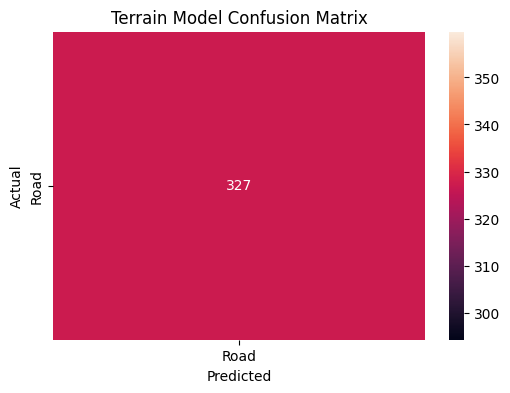

Best Position Model Accuracy: 100.00%


/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


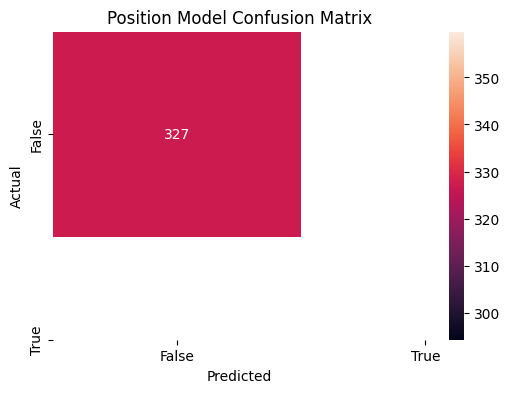

In [8]:

# Step 6: Evaluate the Best Models

# Cadence Model Evaluation
y_pred_cadence = best_cadence_model.predict(X_test)
mae_cadence = mean_absolute_error(y_test_cadence, y_pred_cadence)
rmse_cadence = np.sqrt(mean_squared_error(y_test_cadence, y_pred_cadence))
print(f'\nBest Cadence Model MAE: {mae_cadence:.2f}')
print(f'Best Cadence Model RMSE: {rmse_cadence:.2f}')

# Terrain Model Evaluation
y_pred_terrain = best_terrain_model.predict(X_test)
accuracy_terrain = accuracy_score(y_test_terrain, y_pred_terrain)
print(f'Best Terrain Model Accuracy: {accuracy_terrain:.2%}')

# Confusion Matrix for Terrain
cm_terrain = confusion_matrix(y_test_terrain, y_pred_terrain)
plt.figure(figsize=(6,4))
sns.heatmap(cm_terrain, annot=True, fmt='d', xticklabels=terrain_encoder.classes_, yticklabels=terrain_encoder.classes_)
plt.title('Terrain Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Position Model Evaluation
y_pred_position = best_position_model.predict(X_test)
accuracy_position = accuracy_score(y_test_position, y_pred_position)
print(f'Best Position Model Accuracy: {accuracy_position:.2%}')

# Confusion Matrix for Position
cm_position = confusion_matrix(y_test_position, y_pred_position)
plt.figure(figsize=(6,4))
sns.heatmap(cm_position, annot=True, fmt='d', xticklabels=position_encoder.classes_, yticklabels=position_encoder.classes_)
plt.title('Position Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [9]:

# Step 7: Collect Trial Results for Analysis

# Collect inference times, MAE, and other metrics from the trials
trial_results = []
for trial in study.trials:
    trial_results.append({
        'trial_number': trial.number,
        'mae_cadence': trial.user_attrs.get('mae_cadence', None),
        'inference_time': trial.user_attrs.get('inference_time', None),
        'model_type': trial.user_attrs.get('model_type', None),
        'window_size': trial.user_attrs.get('window_size', None),
        'window_step': trial.user_attrs.get('window_step', None),
    })

trial_results_df = pd.DataFrame(trial_results)


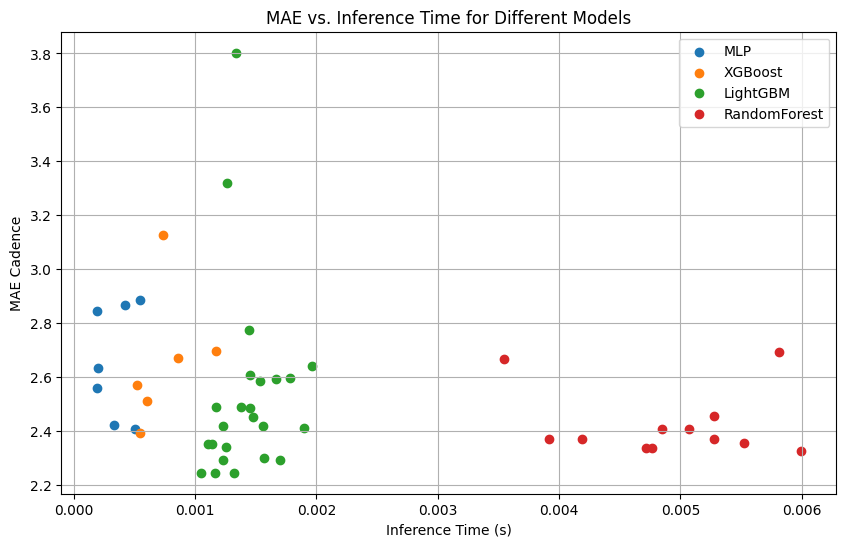

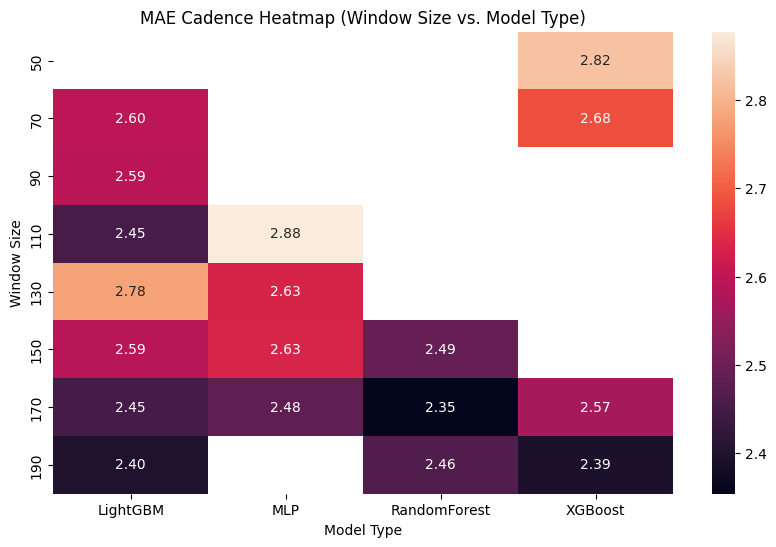

In [10]:

# Step 8: Visualize the Results

# Plot MAE vs. Inference Time
plt.figure(figsize=(10, 6))
for model_type in trial_results_df['model_type'].unique():
    subset = trial_results_df[trial_results_df['model_type'] == model_type]
    plt.scatter(subset['inference_time'], subset['mae_cadence'], label=model_type)

plt.xlabel('Inference Time (s)')
plt.ylabel('MAE Cadence')
plt.title('MAE vs. Inference Time for Different Models')
plt.legend()
plt.grid(True)
plt.show()

# Heatmap of Hyperparameters vs. MAE
pivot_table = trial_results_df.pivot_table(values='mae_cadence', index='window_size', columns='model_type')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f")
plt.title('MAE Cadence Heatmap (Window Size vs. Model Type)')
plt.xlabel('Model Type')
plt.ylabel('Window Size')
plt.show()


In [11]:

# Step 9: Displaying Results

# Create a DataFrame to display actual vs predicted values
results_df = pd.DataFrame({
    'Actual Cadence': y_test_cadence,
    'Predicted Cadence': y_pred_cadence,
    'Actual Gear': y_test_gear,  # Use y_test_gear
    'Speed': np.array([item['speed'] for item in X_test_raw]),  # Extract speed from raw data
})

# Calculate the calculated gear from predicted cadence and speed
def calculate_gear(cadence, speed, wheel_circumference, gear_ratios):
    if speed == 0:
        return np.nan
    # Calculate gear ratio
    gear_ratio_calculated = (cadence * wheel_circumference) / (speed * 60)
    # Match to the closest gear ratio
    gear_ratio_values = np.array(list(gear_ratios.values()))
    gear_numbers = np.array(list(gear_ratios.keys()))
    idx = (np.abs(gear_ratio_values - gear_ratio_calculated)).argmin()
    predicted_gear = gear_numbers[idx]
    return predicted_gear

# Apply the calculation to each sample
predicted_gears = []
for idx in range(len(results_df)):
    cadence = results_df.loc[idx, 'Predicted Cadence']
    speed = results_df.loc[idx, 'Speed']
    # Avoid division by zero
    if speed > 0:
        predicted_gear = calculate_gear(cadence, speed, wheel_circumference, gear_ratios)
    else:
        predicted_gear = np.nan
    predicted_gears.append(predicted_gear)

results_df['Predicted Gear'] = predicted_gears

# Display the results table
results_df.reset_index(drop=True, inplace=True)
print("\nSample of Results:")
print(results_df[['Actual Cadence', 'Predicted Cadence', 'Actual Gear', 'Predicted Gear']].head(20))

# Step 10: Visualizing with a Dynamic Graph (Modified)

# Set up the data for plotting
time_series = range(len(y_test_cadence))  # Or use actual timestamps if available
actual_cadence = results_df['Actual Cadence']
predicted_cadence = results_df['Predicted Cadence']
actual_gear = results_df['Actual Gear']
predicted_gear = results_df['Predicted Gear']

# Now, define the function for the interactive plot
def plot_with_slider(window_start):
    idx = window_start  # Each index corresponds to one window

    # Plot accelerometer data
    fig, axs = plt.subplots(4, 1, figsize=(12, 16))

    accel_x = X_test_raw[idx]['accel_x']
    accel_y = X_test_raw[idx]['accel_y']
    accel_z = X_test_raw[idx]['accel_z']
    time_accel = np.arange(len(accel_x)) / 50  # Assuming 50 Hz sampling rate

    axs[0].plot(time_accel, accel_x, label='Accel X')
    axs[0].plot(time_accel, accel_y, label='Accel Y')
    axs[0].plot(time_accel, accel_z, label='Accel Z')
    axs[0].set_title('Accelerometer Data')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Acceleration')
    axs[0].legend()

    # Plot actual vs predicted cadence
    axs[1].bar(['Actual Cadence', 'Predicted Cadence'], [actual_cadence.iloc[idx], predicted_cadence.iloc[idx]], color=['blue', 'orange'])
    axs[1].set_title('Actual vs. Predicted Cadence')
    axs[1].set_ylabel('Cadence (RPM)')
    axs[1].set_ylim(0, max(actual_cadence.max(), predicted_cadence.max()))

    # Plot actual gear vs predicted gear
    axs[2].bar(['Actual Gear', 'Predicted Gear'], [actual_gear.iloc[idx], predicted_gear[idx]], color=['green', 'red'])
    axs[2].set_title('Actual vs. Predicted Gear')
    axs[2].set_ylabel('Gear Number')
    axs[2].set_ylim(0, max(actual_gear.max(), predicted_gear.max()))

    # Plot speed
    axs[3].bar(['Speed'], [results_df.loc[idx, 'Speed']], color='purple')
    axs[3].set_title('Speed')
    axs[3].set_ylabel('Speed (m/s)')
    axs[3].set_ylim(0, results_df['Speed'].max())

    plt.tight_layout()
    plt.show()

window_slider = IntSlider(min=0, max=len(X_test_raw)-1, step=1, description='Window Index')
interactive_plot = interactive(plot_with_slider, window_start=window_slider)
display(interactive_plot)


Sample of Results:
    Actual Cadence  Predicted Cadence  Actual Gear  Predicted Gear
0        18.949802          15.693141            3               4
1        11.588976          10.950408            3               3
2        11.966643          10.829397            3               4
3         6.287687           5.321003            3               4
4         4.476561           4.711913            5               4
5         3.852870           4.529245            5               4
6         3.506495           3.574571            5               5
7         1.558187           1.509545            5               5
8         2.324194           2.447044            5               5
9         6.276962           6.072809            5               5
10        7.607606           5.729969            5               6
11        5.354209           4.361760            5               6
12        4.211993           4.665651            6               5
13        5.661807           7.868245     

interactive(children=(IntSlider(value=0, description='Window Index', max=326), Output()), _dom_classes=('widge…

In [12]:
# Now show the entire dataset with this interactive plot
window_slider = IntSlider(min=0, max=len(X_test_raw)-1, step=1, description='Window Index')
interactive_plot = interactive(plot_with_slider, window_start=window_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Window Index', max=326), Output()), _dom_classes=('widge…

In [ ]:
# Step 10: Visualizing with a Dynamic Graph

# Set up the data for plotting
time_series = range(len(y_test_cadence))  # Or use actual timestamps if available
actual_cadence = results_df['Actual Cadence']
predicted_cadence = results_df['Predicted Cadence']

# Function to plot a section of the data with slider
def plot_with_slider(window_start):
    window_end = window_start + 50  # Adjust window size for plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_series[window_start:window_end], actual_cadence[window_start:window_end], label="Actual Cadence", color="blue")
    plt.plot(time_series[window_start:window_end], predicted_cadence[window_start:window_end], label="Predicted Cadence", color="orange")
    plt.xlabel("Sample Index")
    plt.ylabel("Cadence (RPM)")
    plt.legend()
    plt.title("Actual vs. Predicted Cadence")
    plt.show()

# Ensure max value is at least equal to min value
max_slider_value = max(0, len(time_series) - 50)
window_slider = IntSlider(min=0, max=max_slider_value, step=1, description='Time Window')
interactive_plot = interactive(plot_with_slider, window_start=window_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Time Window', max=277), Output()), _dom_classes=('widget…